/tmp/ipykernel_328/2691237340.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("outputs/resnet_best.pt", map_location=device))


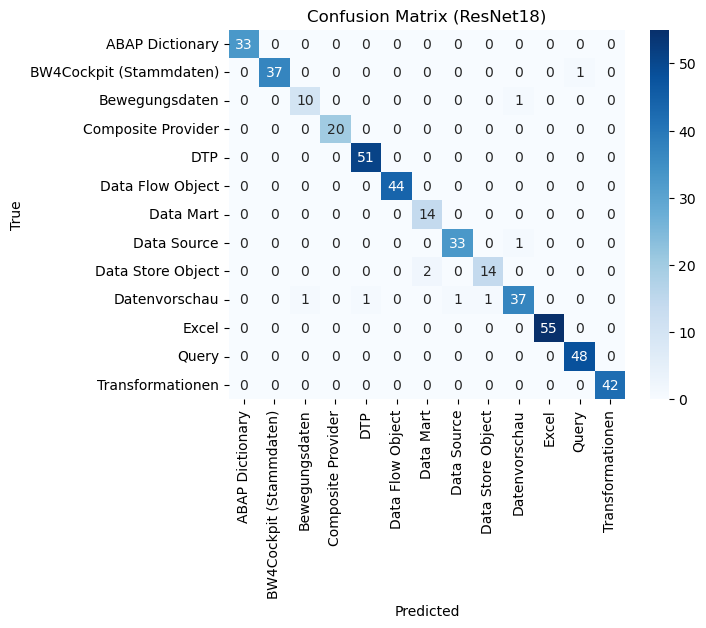

                         precision    recall  f1-score   support

        ABAP Dictionary       1.00      1.00      1.00        33
BW4Cockpit (Stammdaten)       1.00      0.97      0.99        38
         Bewegungsdaten       0.91      0.91      0.91        11
     Composite Provider       1.00      1.00      1.00        20
                    DTP       0.98      1.00      0.99        51
       Data Flow Object       1.00      1.00      1.00        44
              Data Mart       0.88      1.00      0.93        14
            Data Source       0.97      0.97      0.97        34
      Data Store Object       0.93      0.88      0.90        16
          Datenvorschau       0.95      0.90      0.93        41
                  Excel       1.00      1.00      1.00        55
                  Query       0.98      1.00      0.99        48
       Transformationen       1.00      1.00      1.00        42

               accuracy                           0.98       447
              macro avg

In [3]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Nutze denselben Ordner wie fürs Training
data_root = "/workspace/Projekt/Testdaten/Data/SAP Bilder sortiert"
eval_data = datasets.ImageFolder(data_root, transform=transform_eval)
eval_loader = DataLoader(eval_data, batch_size=32, shuffle=False)


model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, len(eval_data.classes))
model = model.to(device)

model.load_state_dict(torch.load("outputs/resnet_best.pt", map_location=device))
model.eval()

#confusion Matrix
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in eval_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

# Confusion Matrix plotten
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=eval_data.classes,
            yticklabels=eval_data.classes)
plt.title("Confusion Matrix (ResNet18)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report ausgeben
print(classification_report(y_true, y_pred, target_names=eval_data.classes))

In [2]:
import torch
from torchvision import transforms, models, datasets
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# === Klassenliste aus Trainingsdaten ===
train_data = datasets.ImageFolder("/workspace/Projekt/Testdaten/Data/SAP Bilder sortiert",
                                  transform=transform_val)
classes = train_data.classes


model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
state = torch.load("outputs/resnet_best.pt", map_location=device)
model.load_state_dict(state)
model = model.to(device)
model.eval()


def predict_topk(image_path, k=3):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform_val(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1).squeeze(0)
        top_probs, top_idxs = probs.topk(k)
    return [(classes[int(i)], float(p)) for p, i in zip(top_probs.cpu(), top_idxs.cpu())]

image_path = "/workspace/Projekt/Testdaten/Data/Ungelabelt/2a9fb1ed563a4c77924b7d5d5cae6bd0.jpeg"
print("Top-3 Vorhersagen:", predict_topk(image_path, k=3))

/tmp/ipykernel_449/25611651.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("outputs/resnet_best.pt", map_location=device)


Top-3 Vorhersagen: [('Excel', 0.7793262004852295), ('DTP', 0.06862715631723404), ('Data Mart', 0.04592373967170715)]
